## Connect to Drive Account

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
    print("You are not working in Colab at the moment :(")

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Sentiment Analysis/Data'

/content/drive/.shortcut-targets-by-id/1WcN1Xj_6ZlvgCWQvR35DZ3Vc8GoeGpYU/Sentiment Analysis/Data


## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import wordcloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import os

## Getting Data

In [ ]:
df1 = pd.read_csv("train.csv")
df2 = pd.read_csv("test.csv")
sentiSet = pd.concat([df1, df2])
sentiSet.drop_duplicates(inplace=True)
df = pd.read_csv("datawithoutstopwordswithlemmas.csv")
data = pd.concat([df["find_lemmas"], sentiSet['label']])

In [ ]:
sentiSet['label'].value_counts()

Positive    261837
Notr        170917
Negative     56358
Name: label, dtype: int64

In [ ]:
data = pd.concat([df["find_lemmas"], sentiSet['label']])

In [ ]:
data_pos = data[data.label == "Positive"]
data_neg = data[data.label == "Negative"]
data_notr = data[data.label == "Notr"]

In [ ]:
# one way to fix it is to downsample the ham msg
pos = data_pos.sample(n = len(data_notr), random_state = 44)
neg = data_neg.sample(n = len(data_notr), random_state = 44)
notr = data_notr
print(pos.shape, neg.shape, notr.shape)

In [ ]:
df = pd.concat([pos, neg, notr])

#Machine Learning

##Transform with BoW Method

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(df['find_lemmas'].values.astype('U'))

tfidf.shape

(489112, 10000)

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(tfidf, sentiSet['label'], test_size=0.2, random_state=42)

## Lojistic Regression

### Grid Search

In [ ]:
# Grid Search kullanarak hiperparametrelerin en iyi kombinasyonunu bulabiliriz
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Modelimizi tanımlayalım
model = LogisticRegression(max_iter=500)

# Grid Search ile hiperparametre optimizasyonu yapalım
parameters = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(model, parameters, cv=5)
grid_search.fit(xtrain, ytrain)

In [ ]:
print('Best Parameters:', grid_search.best_params_)
print('Best Score:', grid_search.best_score_)

Best Parameters: {'C': 1, 'penalty': 'l2'}
Best Score: 0.9213675832318545


### Cross Validation

In [ ]:
# K-Fold Cross Validation kullanarak model performansını ölçebiliriz
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import pandas as pd

# Modelimizi tanımlayalım
model = LogisticRegression(max_iter=500)

# Cross validation ile model performansını ölçelim
scores = cross_val_score(model, xtrain, ytrain, cv=5)
print('Cross Validation Scores:', scores)
print('Mean Score:', scores.mean())

Cross Validation Scores: [0.92256383 0.92287051 0.92023819 0.92233382 0.92243505]
Mean Score: 0.9220882783486768


### RFE değişken Seçimi

In [ ]:
# Recursive feature elimination (RFE) kullanarak değişken seçimi yapabiliriz
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import pandas as pd

# RFE kullanarak en önemli değişkenleri seçelim
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=5)
rfe.fit(xtrain, ytrain)
selected_features = xtrain.columns[rfe.support_]

# Seçilen değişkenleri kullanarak modelimizi eğitelim
xtrain_selected = df[selected_features]
model.fit(xtrain_selected, ytrain)

# Modelimizin performansını test edelim
score = model.score(xtrain_selected, ytrain)
print('Model Score:', score)

### Train LR Model

In [ ]:
from datetime import datetime
from sklearn.linear_model import LogisticRegression

start = datetime.now()
lr = LogisticRegression(random_state=42, max_iter=500)
lr.fit(xtrain, ytrain)
end = datetime.now()

lr.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.

print(end - start)

0:01:04.846628


In [ ]:
pred = lr.predict(xtest)
print(classification_report(ytest, pred))
print()
print("Confusion Matrix: \n", confusion_matrix(ytest, pred))
print("Accuracy: \n", accuracy_score(ytest, pred))

              precision    recall  f1-score   support

    Negative       0.83      0.65      0.73     11278
        Notr       0.95      0.98      0.96     33994
    Positive       0.92      0.95      0.94     52551

    accuracy                           0.92     97823
   macro avg       0.90      0.86      0.88     97823
weighted avg       0.92      0.92      0.92     97823


Confusion Matrix: 
 [[ 7289   425  3564]
 [  110 33179   705]
 [ 1333  1303 49915]]
Accuracy: 
 0.9239442666857488


## Data Labeling

### Hepsiburada veri

In [ ]:
%cd '/content/drive/MyDrive/Sentiment Analysis/With New Method'

/content/drive/MyDrive/Sentiment Analysis/With New Method


In [ ]:
tag_set = pd.read_csv("process_data_hb.csv")
tag_set.head()

,Unnamed: 0.1,Unnamed: 0,Date,UserName,tweets,find_lemmas
0,0,0,2023-03-17,Maytap2020,@hepsiburada @hanzadedogan Ürünleri satıp satı...,ürün sat sat iptal et firma deprem bile çıkar ...
1,1,1,2023-03-17,AlpayBilgin,#hepsiburada Siz şakamısınız acaba?\nFahiş fiy...,hepsiburada siz UNK fahiş fiyat art UNK kayıt ...
2,2,2,2023-03-17,AgcicekGorkem,"HepsiBurada Premium ücretine zam geldi 9,90₺'d...",hepsiburada premium ücret zam gel dan ol hepsi...
3,3,3,2023-03-17,teknodiot,#Hepsiburada Premium ücretlerine zam geldi. Ay...,hepsiburada premium ücret zam gel aylık ol üye...
4,4,4,2023-03-17,salihsamiracar,Hepsiburada Premium 23 Mart 2023’ten itibaren ...,hepsiburada premium mart ten itibaren yerine o...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
tfidf_tag = tfidf_vectorizer.fit_transform(tag_set['find_lemmas'].values.astype('U'))

tfidf_tag.shape

(6975, 10000)

In [ ]:
labels = lr.predict(tfidf_tag)
label_df = pd.DataFrame(labels, columns=["label"])
# label_df.to_csv("labels.csv")
label_df.value_counts()

label   
Notr        4152
Positive    2700
Negative     123
dtype: int64

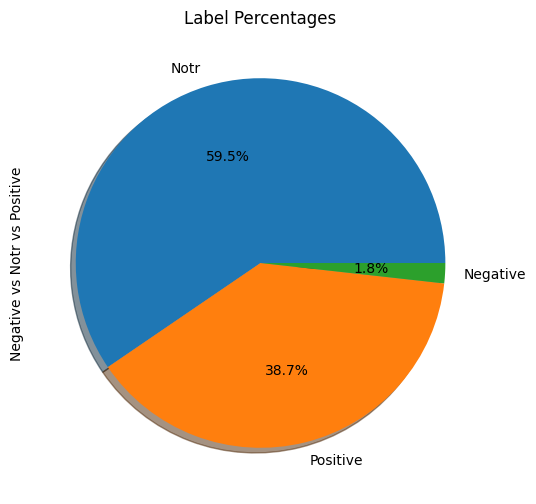

In [ ]:
label_df["label"].value_counts().plot(kind = 'pie', figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Negative vs Notr vs Positive")
plt.title("Label Percentages")
# plt.legend(["Negative", "Notr", "Positive"])
plt.show()

In [ ]:
tag_set["label"] = label_df["label"]

In [ ]:
tag_set.head()

,Unnamed: 0.1,Unnamed: 0,Date,UserName,tweets,find_lemmas,label
0,0,0,2023-03-17,Maytap2020,@hepsiburada @hanzadedogan Ürünleri satıp satı...,ürün sat sat iptal et firma deprem bile çıkar ...,Positive
1,1,1,2023-03-17,AlpayBilgin,#hepsiburada Siz şakamısınız acaba?\nFahiş fiy...,hepsiburada siz UNK fahiş fiyat art UNK kayıt ...,Positive
2,2,2,2023-03-17,AgcicekGorkem,"HepsiBurada Premium ücretine zam geldi 9,90₺'d...",hepsiburada premium ücret zam gel dan ol hepsi...,Notr
3,3,3,2023-03-17,teknodiot,#Hepsiburada Premium ücretlerine zam geldi. Ay...,hepsiburada premium ücret zam gel aylık ol üye...,Notr
4,4,4,2023-03-17,salihsamiracar,Hepsiburada Premium 23 Mart 2023’ten itibaren ...,hepsiburada premium mart ten itibaren yerine o...,Positive


In [ ]:
tag_set.to_csv("labelled_hb_data.csv")
tag_set.to_excel("labelled_hb_data.xlsx")

### Trendyol veri

In [ ]:
%cd '/content/drive/MyDrive/Sentiment Analysis/With New Method'

/content/drive/.shortcut-targets-by-id/1WcN1Xj_6ZlvgCWQvR35DZ3Vc8GoeGpYU/Sentiment Analysis/With New Method


In [ ]:
tag_set = pd.read_csv("process_data_ty.csv")
tag_set.head()

,Unnamed: 0.1,Unnamed: 0,Date,UserName,tweets,find_lemmas
0,0,0,2023-03-17,suvaytr,Ev tekstilinde #Trendyol fırsatlarını kaçırma....,tekstil trendyol fırsat kaçır UNK micro UNK sı...
1,1,1,2023-03-17,makcay0606,@TrendyolDestek Dertsiz başına dert almak iste...,UNK dert baş dert al iste trendyol alışveriş yap
2,2,2,2023-03-17,Football_trk,@Trendyol hayirli reklamlar. Yardim mi reklam ...,trendyol UNK reklam yar reklam UNK UNK kesk UN...
3,3,3,2023-03-17,dkorganization,Neydi o ? \nBir elin verdiğini diğer el görmel...,ne bir el ver diğer gör mi trendyol
4,4,4,2023-03-17,fatihua7,Trandyol hiç yakışmadı!!! #trendyol,UNK yakış trendyol


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,3))
tfidf_tag = tfidf_vectorizer.fit_transform(tag_set['find_lemmas'].values.astype('U'))

tfidf_tag.shape

(6997, 10000)

In [ ]:
labels = lr.predict(tfidf_tag)
label_df = pd.DataFrame(labels, columns=["label"])
# label_df.to_csv("labels.csv")
label_df.value_counts()

label   
Notr        4178
Positive    2653
Negative     166
dtype: int64

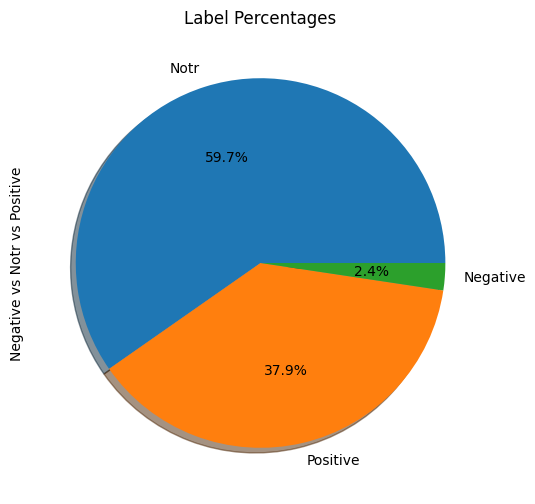

In [ ]:
label_df["label"].value_counts().plot(kind = 'pie', figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Negative vs Notr vs Positive")
plt.title("Label Percentages")
# plt.legend(["Negative", "Notr", "Positive"])
plt.show()

In [ ]:
tag_set.drop(["Unnamed: 0.1", "Unnamed: 0"], axis=1, inplace=True)

In [ ]:
tag_set["label"] = label_df["label"]
tag_set.to_csv("labelled_ty_data.csv")
tag_set.to_excel("labelled_ty_data.xlsx")

### THY veri

In [ ]:
%cd '/content/drive/MyDrive/Sentiment Analysis/With New Method'

/content/drive/.shortcut-targets-by-id/1WcN1Xj_6ZlvgCWQvR35DZ3Vc8GoeGpYU/Sentiment Analysis/With New Method


In [ ]:
tag_set = pd.read_csv("process_data_thy.csv")
tag_set.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Date,UserName,tweets,processed_data,label
0,0,0,0,2023-03-17,emlakkulisicomm,Tatil yolları gözleyenlere indirim Türk Hava Y...,tatil yol gözle indirim türk hava yol indirim ...,Positive
1,1,1,1,2023-03-17,TK_TR,✈️🏆\nUEFA Şampiyonlar Ligi Çeyrek Final eşleşm...,uefa şampiyon ligi çeyrek final eş belli ol UN...,Notr
2,2,2,2,2023-03-17,Kap_Haber,"#THYAO Türk Hava Yolları, 16.03.2023 tarihinde...",UNK türk hava yol tarih borsa istanbul pay baş...,Positive
3,3,3,3,2023-03-16,hakan80527278,Fenerbahce nin forma reklamında niye Türk Hava...,UNK UNK forma reklam türk hava yol yaz UNK thy,Notr
4,4,4,4,2023-03-16,haberaircom,Türk Hava Yolları Stuttgart seferlerini iptal ...,türk hava yol stuttgart sefer iptal et thy stu...,Positive


In [ ]:
tag_set.drop(["Unnamed: 0.2", "Unnamed: 0.1", "Unnamed: 0"], axis=1, inplace=True)

In [ ]:
tag_set.head()

,Date,UserName,tweets,processed_data,label
0,2023-03-17,emlakkulisicomm,Tatil yolları gözleyenlere indirim Türk Hava Y...,tatil yol gözle indirim türk hava yol indirim ...,Positive
1,2023-03-17,TK_TR,✈️🏆\nUEFA Şampiyonlar Ligi Çeyrek Final eşleşm...,uefa şampiyon ligi çeyrek final eş belli ol UN...,Notr
2,2023-03-17,Kap_Haber,"#THYAO Türk Hava Yolları, 16.03.2023 tarihinde...",UNK türk hava yol tarih borsa istanbul pay baş...,Positive
3,2023-03-16,hakan80527278,Fenerbahce nin forma reklamında niye Türk Hava...,UNK UNK forma reklam türk hava yol yaz UNK thy,Notr
4,2023-03-16,haberaircom,Türk Hava Yolları Stuttgart seferlerini iptal ...,türk hava yol stuttgart sefer iptal et thy stu...,Positive


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
tfidf_tag = tfidf_vectorizer.fit_transform(tag_set['processed_data'].values.astype('U'))

tfidf_tag.shape

(5844, 10000)

In [ ]:
labels = lr.predict(tfidf_tag)
label_df = pd.DataFrame(labels, columns=["label"])
# label_df.to_csv("labels.csv")
label_df.value_counts()

label   
Positive    3244
Notr        2400
Negative     200
dtype: int64

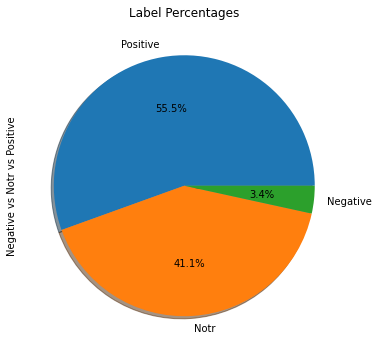

In [ ]:
label_df["label"].value_counts().plot(kind = 'pie', figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Negative vs Notr vs Positive")
plt.title("Label Percentages")
# plt.legend(["Negative", "Notr", "Positive"])
plt.show()

In [ ]:
df = pd.concat([tag_set, label_df], axis=1)

In [ ]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Date,UserName,tweets,remove_mentions,remove_links,remove_punctuation,remove_emojis,remove_stopwords,remove_numbers,correct_chars,remove_non_tr,remove_2_ch,remove_tags,lower_ch,strip_spaces,find_lemmas,label
0,0,0,2023-03-17,emlakkulisicomm,Tatil yolları gözleyenlere indirim Türk Hava Y...,Tatil yolları gözleyenlere indirim Türk Hava Y...,Tatil yolları gözleyenlere indirim Türk Hava Y...,Tatil yolları gözleyenlere indirim Türk Hava Y...,Tatil yolları gözleyenlere indirim Türk Hava Y...,Tatil yolları gözleyenlere indirim Türk Hava Y...,Tatil yolları gözleyenlere indirim Türk Hava Y...,Tatil yolları gözleyenlere indirim Türk Hava Y...,Tatil yolları gözleyenlere indirim Türk Hava Y...,Tatil yolları gözleyenlere indirim Türk Hava Y...,Tatil yolları gözleyenlere indirim Türk Hava Y...,tatil yolları gözleyenlere indirim türk hava y...,tatil yolları gözleyenlere indirim türk hava y...,tatil yol gözle indirim türk hava yol indirim ...,Positive
1,1,1,2023-03-17,TK_TR,✈️🏆\nUEFA Şampiyonlar Ligi Çeyrek Final eşleşm...,✈️🏆\nUEFA Şampiyonlar Ligi Çeyrek Final eşleşm...,✈️🏆\nUEFA Şampiyonlar Ligi Çeyrek Final eşleşm...,✈️🏆\nUEFA Şampiyonlar Ligi Çeyrek Final eşleşm...,\nUEFA Şampiyonlar Ligi Çeyrek Final eşleşmel...,UEFA Şampiyonlar Ligi Çeyrek Final eşleşmeleri...,UEFA Şampiyonlar Ligi Çeyrek Final eşleşmeleri...,UEFA Şampiyonlar Ligi Çeyrek Final eşleşmeleri...,UEFA Şampiyonlar Ligi Çeyrek Final eşleşmeleri...,UEFA Şampiyonlar Ligi Çeyrek Final eşleşmeleri...,UEFA Şampiyonlar Ligi Çeyrek Final eşleşmeleri...,uefa şampiyonlar ligi çeyrek final eşleşmeleri...,uefa şampiyonlar ligi çeyrek final eşleşmeleri...,uefa şampiyon ligi çeyrek final eş belli ol UN...,Notr
2,2,2,2023-03-17,Kap_Haber,"#THYAO Türk Hava Yolları, 16.03.2023 tarihinde...","#THYAO Türk Hava Yolları, 16.03.2023 tarihinde...","#THYAO Türk Hava Yolları, 16.03.2023 tarihinde...",THYAO Türk Hava Yolları 16032023 tarihinde Bor...,THYAO Türk Hava Yolları 16032023 tarihinde Bor...,THYAO Türk Hava Yolları 16032023 tarihinde Bor...,THYAO Türk Hava Yolları tarihinde Borsa İsta...,THYAO Türk Hava Yolları tarihinde Borsa İsta...,THYAO Türk Hava Yolları tarihinde Borsa İsta...,THYAO Türk Hava Yolları tarihinde Borsa İstanb...,THYAO Türk Hava Yolları tarihinde Borsa İstanb...,thyao türk hava yolları tarihinde borsa istanb...,thyao türk hava yolları tarihinde borsa istanb...,UNK türk hava yol tarih borsa istanbul pay baş...,Positive
3,3,3,2023-03-16,hakan80527278,Fenerbahce nin forma reklamında niye Türk Hava...,Fenerbahce nin forma reklamında niye Türk Hava...,Fenerbahce nin forma reklamında niye Türk Hava...,Fenerbahce nin forma reklamında niye Türk Hava...,Fenerbahce nin forma reklamında niye Türk Hava...,Fenerbahce nin forma reklamında Türk Hava Yoll...,Fenerbahce nin forma reklamında Türk Hava Yoll...,Fenerbahce nin forma reklamında Türk Hava Yoll...,Fenerbahce nin forma reklamında Türk Hava Yoll...,Fenerbahce nin forma reklamında Türk Hava Yoll...,Fenerbahce nin forma reklamında Türk Hava Yoll...,fenerbahce nin forma reklamında türk hava yoll...,fenerbahce nin forma reklamında türk hava yoll...,UNK UNK forma reklam türk hava yol yaz UNK thy,Notr
4,4,4,2023-03-16,haberaircom,Türk Hava Yolları Stuttgart seferlerini iptal ...,Türk Hava Yolları Stuttgart seferlerini iptal ...,Türk Hava Yolları Stuttgart seferlerini iptal ...,Türk Hava Yolları Stuttgart seferlerini iptal ...,Türk Hava Yolları Stuttgart seferlerini iptal ...,Türk Hava Yolları Stuttgart seferlerini iptal ...,Türk Hava Yolları Stuttgart seferlerini iptal ...,Türk Hava Yolları Stuttgart seferlerini iptal ...,Türk Hava Yolları Stuttgart seferlerini iptal ...,Türk Hava Yolları Stuttgart seferlerini iptal ...,Türk Hava Yolları Stuttgart seferlerini iptal ...,türk hava yolları stuttgart seferlerini iptal ...,türk hava yolları stuttgart seferlerini iptal ...,türk hava yol stuttgart sefer iptal et thy stu...,Positive


In [ ]:
df.drop(['remove_mentions', 'remove_links', 'remove_punctuation', 'remove_emojis', 'remove_stopwords', 'remove_numbers', 'correct_chars', 'remove_non_tr', 'remove_2_ch', 'remove_tags', 'lower_ch', 'strip_spaces'], axis=1, inplace=True)

In [ ]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Date,UserName,tweets,find_lemmas,label
0,0,0,2023-03-17,emlakkulisicomm,Tatil yolları gözleyenlere indirim Türk Hava Y...,tatil yol gözle indirim türk hava yol indirim ...,Positive
1,1,1,2023-03-17,TK_TR,✈️🏆\nUEFA Şampiyonlar Ligi Çeyrek Final eşleşm...,uefa şampiyon ligi çeyrek final eş belli ol UN...,Notr
2,2,2,2023-03-17,Kap_Haber,"#THYAO Türk Hava Yolları, 16.03.2023 tarihinde...",UNK türk hava yol tarih borsa istanbul pay baş...,Positive
3,3,3,2023-03-16,hakan80527278,Fenerbahce nin forma reklamında niye Türk Hava...,UNK UNK forma reklam türk hava yol yaz UNK thy,Notr
4,4,4,2023-03-16,haberaircom,Türk Hava Yolları Stuttgart seferlerini iptal ...,türk hava yol stuttgart sefer iptal et thy stu...,Positive


In [ ]:
df.rename({
    'find_lemmas': 'processed_data'
}, axis=1, inplace= True)

In [ ]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Date,UserName,tweets,processed_data,label
0,0,0,2023-03-17,emlakkulisicomm,Tatil yolları gözleyenlere indirim Türk Hava Y...,tatil yol gözle indirim türk hava yol indirim ...,Positive
1,1,1,2023-03-17,TK_TR,✈️🏆\nUEFA Şampiyonlar Ligi Çeyrek Final eşleşm...,uefa şampiyon ligi çeyrek final eş belli ol UN...,Notr
2,2,2,2023-03-17,Kap_Haber,"#THYAO Türk Hava Yolları, 16.03.2023 tarihinde...",UNK türk hava yol tarih borsa istanbul pay baş...,Positive
3,3,3,2023-03-16,hakan80527278,Fenerbahce nin forma reklamında niye Türk Hava...,UNK UNK forma reklam türk hava yol yaz UNK thy,Notr
4,4,4,2023-03-16,haberaircom,Türk Hava Yolları Stuttgart seferlerini iptal ...,türk hava yol stuttgart sefer iptal et thy stu...,Positive


In [ ]:
tag_set.to_csv("labelled_data_thy.csv")
tag_set.to_excel("labelled_data_thy.xlsx")

###LC W Veri

In [ ]:
%cd '/content/drive/MyDrive/Sentiment Analysis/With New Method'

/content/drive/.shortcut-targets-by-id/1WcN1Xj_6ZlvgCWQvR35DZ3Vc8GoeGpYU/Sentiment Analysis/With New Method


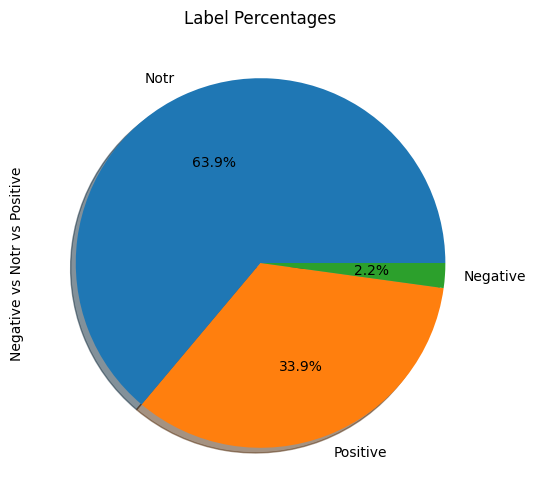

In [ ]:
tag_set = pd.read_csv("process_data_lc.csv")
tag_set.head()

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
tfidf_tag = tfidf_vectorizer.fit_transform(tag_set['find_lemmas'].values.astype('U'))

tfidf_tag.shape

labels = lr.predict(tfidf_tag)
label_df = pd.DataFrame(labels, columns=["label"])
# label_df.to_csv("labels.csv")
label_df.value_counts()

label_df["label"].value_counts().plot(kind = 'pie', figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Negative vs Notr vs Positive")
plt.title("Label Percentages")
# plt.legend(["Negative", "Notr", "Positive"])
plt.show()

In [ ]:
tag_set["label"] = label_df["label"]
tag_set.to_csv("labelled_lcw_data.csv")
tag_set.to_excel("labelled_lcw_data.xlsx")

### DF Veri

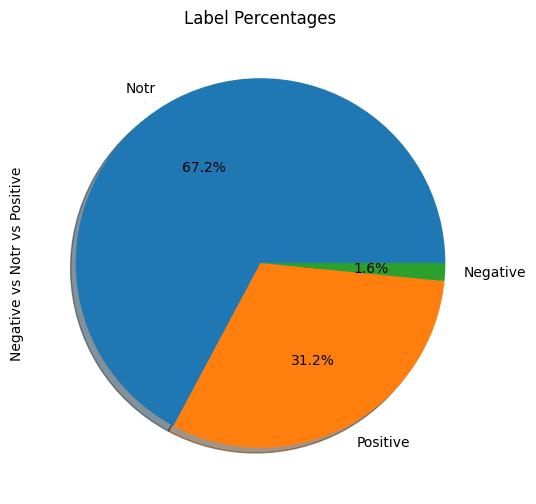

In [ ]:
tag_set = pd.read_csv("process_data_df.csv")
tag_set.head()

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
tfidf_tag = tfidf_vectorizer.fit_transform(tag_set['find_lemmas'].values.astype('U'))

tfidf_tag.shape

labels = lr.predict(tfidf_tag)
label_df = pd.DataFrame(labels, columns=["label"])
# label_df.to_csv("labels.csv")
label_df.value_counts()

label_df["label"].value_counts().plot(kind = 'pie', figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Negative vs Notr vs Positive")
plt.title("Label Percentages")
# plt.legend(["Negative", "Notr", "Positive"])
plt.show()

In [ ]:
tag_set["label"] = label_df["label"]
tag_set.to_csv("labelled_df_data.csv")
tag_set.to_excel("labelled_df_data.xlsx")

##SVM

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pickle
clf = make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto'))
start = datetime.now()
clf.fit(xtrain, ytrain)

pred = clf.predict(xtest)
print(classification_report(ytest, pred))
print()
print("Confusion Matrix: \n", confusion_matrix(ytest, pred))
print("Accuracy: \n", accuracy_score(ytest, pred))
file_name = "svm_model_hb.pkl"

with open(file_name, 'wb') as f:
    pickle.dump(lr, f)

end = datetime.now()

print(end - start)

In [ ]:
pred = clf.predict(xtest)
print(classification_report(ytest, pred))
print()
print("Confusion Matrix: \n", confusion_matrix(ytest, pred))
print("Accuracy: \n", accuracy_score(ytest, pred))

##Save Model

In [ ]:
import pickle

file_name = "log_reg_model_companies.pkl"

with open(file_name, 'wb') as f:
    pickle.dump(lr, f)